# Visual Only

In [1]:
!pip install numpy opencv-python dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.4-cp310-cp310-linux_x86_64.whl size=3327196 sha256=196004806c9b72643b7f86dfcb861321a8aaa4c090548a16fc31e23b9420d125
  Stored in directory: /root/.cache/pip/wheels/08/5e/55/a7db8d57920eb2c2aa41c36dc4c6d3cd12323865de191a7211
Successfully built dlib


In [6]:
!pip install requests
import requests

def download_file(url, filename):
    # Send a GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Raises an exception for HTTP errors
    
    # Save the file
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f'Download complete: {filename}')

# URL to the dlib pre-trained model for facial landmark detection
url = "https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2"
filename = "shape_predictor_68_face_landmarks.dat.bz2"

download_file(url, filename)

print("Unzipping the file...")

# Unzipping the .bz2 file to get the .dat file
import bz2
with bz2.open(filename, 'rb') as file:
    decompressed_data = file.read()
    with open('shape_predictor_68_face_landmarks.dat', 'wb') as new_file:
        new_file.write(decompressed_data)

print("File is ready to use: shape_predictor_68_face_landmarks.dat")


Download complete: shape_predictor_68_face_landmarks.dat.bz2
Unzipping the file...
File is ready to use: shape_predictor_68_face_landmarks.dat


In [ ]:
import cv2
import dlib
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Initialize dlib's face detector and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/kaggle/working/shape_predictor_68_face_landmarks.dat')

In [8]:

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    landmarks = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        
        for face in faces:
            shape = predictor(gray, face)
            landmark = [(part.x, part.y) for part in shape.parts()]
            landmarks.append(landmark)
    
    cap.release()
    return landmarks

def process_directory(directory):
    data = []
    labels = []
    
    for label in ['Deceptive', 'Truthful']:
        videos_path = os.path.join(directory, label)
        for video_name in os.listdir(videos_path):
            video_path = os.path.join(videos_path, video_name)
            video_landmarks = process_video(video_path)
            data.extend(video_landmarks)
            labels.extend([label] * len(video_landmarks))
    
    return data, labels






In [9]:
# Process videos and extract landmarks
data_dir = '/kaggle/input/real-life-deception-detection/Real-life_Deception_Detection_2016/Clips'
features, labels = process_directory(data_dir)

In [11]:
df = pd.DataFrame({'landmarks': features, 'label': labels})

In [12]:
# Split into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# 0.25 x 0.8 = 0.2
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

In [13]:
# Optionally, save to CSV or another format
train_df.to_csv('train_visual_data.csv', index=False)
val_df.to_csv('val_visual_data.csv', index=False)
test_df.to_csv('test_visual_data.csv', index=False)

In [7]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(49545, 2)
(16515, 2)
(16515, 2)


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Assuming 'landmarks' column in your dataframe contains the landmarks
# Convert landmarks from lists to numpy arrays for processing
train_features = np.array([np.array(x) for x in train_df['landmarks']])
val_features = np.array([np.array(x) for x in val_df['landmarks']])
test_features = np.array([np.array(x) for x in test_df['landmarks']])

# Pad sequences to the same length
train_features_padded = pad_sequences(train_features, padding='post', dtype='float32')
val_features_padded = pad_sequences(val_features, padding='post', dtype='float32')
test_features_padded = pad_sequences(test_features, padding='post', dtype='float32')

# Ensure labels are in the correct shape
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values


In [10]:
input_shape = (train_features_padded.shape[1], train_features_padded.shape[2])  # (timesteps, features)

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import LSTM, Bidirectional

model = models.Sequential([
    layers.Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
    layers.Dropout(0.2),
    layers.Bidirectional(LSTM(128, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(LSTM(128, return_sequences=False)),
    layers.Dense(1, activation='sigmoid'),
                         ])

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 68, 512)        │       530,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 68, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 68, 256)        │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 68, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,581,313 (6.03 MB)

 Trainable params: 1,581,313 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)
test_labels = encoder.transform(test_labels)


NameError: name 'train_labels' is not defined

In [25]:
history = model.fit(
    train_features_padded, train_labels,
    validation_data=(val_features_padded, val_labels),
    epochs=10,
    batch_size=64
)


Epoch 1/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.7905 - loss: 0.4360 - val_accuracy: 0.8324 - val_loss: 0.3522
Epoch 2/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.8404 - loss: 0.3341 - val_accuracy: 0.8503 - val_loss: 0.3178
Epoch 3/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.8510 - loss: 0.3112 - val_accuracy: 0.8624 - val_loss: 0.2962
Epoch 4/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.8614 - loss: 0.2896 - val_accuracy: 0.8930 - val_loss: 0.2233
Epoch 5/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.8726 - loss: 0.2622 - val_accuracy: 0.8848 - val_loss: 0.2419
Epoch 6/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.8807 - loss: 0.2499 - val_accuracy: 0.8708 - val_loss: 0.2647
Epoch 7/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.8899 - loss: 0.2346 - val_accuracy: 0.9038 - val_loss: 0.2135
Epoch 8/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.8980 - loss: 0.2203 - 

In [26]:
test_loss, test_accuracy = model.evaluate(test_features_padded, test_labels)
print(f"Test Accuracy: {test_accuracy}")


517/517 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9216 - loss: 0.1687
Test Accuracy: 0.9194671511650085


In [27]:
pip install matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [28]:
import numpy as np

# Predict probabilities
test_probabilities = model.predict(test_features_padded)
# Convert probabilities to binary predictions (0 or 1)
test_predictions = (test_probabilities > 0.5).astype(int)

517/517 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[7583  919]
 [ 411 7602]]


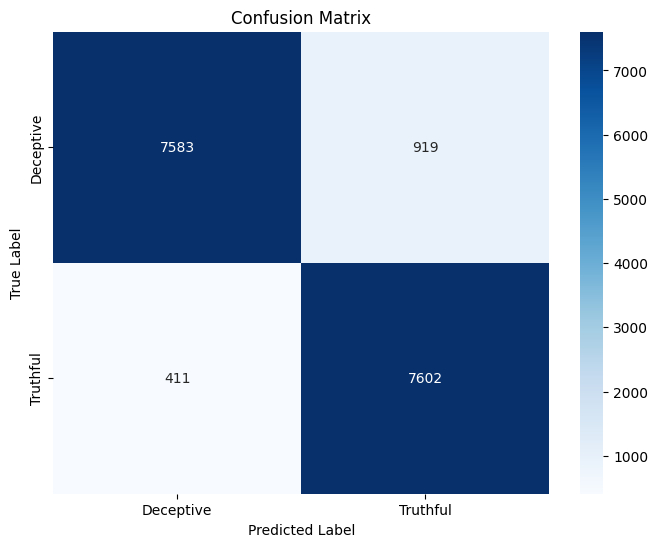

In [30]:
# Heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


load from CSV

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import ast  # to safely evaluate strings containing Python literals

def load_data_from_csv(file_path):
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}.")
        return data
    except Exception as e:
        print(f"Failed to load data from {file_path}. Error: {e}")
        return None

def preprocess_data(df):
    # Convert landmark string representations to actual tuples
    df['landmarks'] = df['landmarks'].apply(ast.literal_eval)

    # Encode labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    return df

# Paths to the CSV files
train_file_path = '/kaggle/working/train_visual_data.csv'
val_file_path = '/kaggle/working/val_visual_data.csv'
test_file_path = '/kaggle/working/test_visual_data.csv'

# Load the datasets
train_df = load_data_from_csv(train_file_path)
val_df = load_data_from_csv(val_file_path)
test_df = load_data_from_csv(test_file_path)

# Preprocess the datasets
train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)
test_df = preprocess_data(test_df)

# Display the first few rows of the train dataset
print("First few rows of the train dataset:")
print(train_df.head())


Data loaded successfully from /kaggle/working/train_visual_data.csv.
Data loaded successfully from /kaggle/working/val_visual_data.csv.
Data loaded successfully from /kaggle/working/test_visual_data.csv.
First few rows of the train dataset:
                                           landmarks  label
0  [(839, 421), (841, 448), (845, 473), (852, 498...      0
1  [(570, 268), (566, 295), (567, 324), (576, 353...      0
2  [(191, 106), (192, 116), (194, 126), (196, 135...      1
3  [(237, 123), (238, 134), (241, 145), (245, 156...      1
4  [(243, 113), (242, 122), (243, 132), (245, 141...      1


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Assuming 'landmarks' column in your dataframe contains the landmarks
# Convert landmarks from lists to numpy arrays for processing
train_features = np.array([np.array(x) for x in train_df['landmarks']])
val_features = np.array([np.array(x) for x in val_df['landmarks']])
test_features = np.array([np.array(x) for x in test_df['landmarks']])

# Pad sequences to the same length
train_features_padded = pad_sequences(train_features, padding='post', dtype='float32')
val_features_padded = pad_sequences(val_features, padding='post', dtype='float32')
test_features_padded = pad_sequences(test_features, padding='post', dtype='float32')

# Ensure labels are in the correct shape
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

2024-06-19 22:15:44.805762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 22:15:44.805920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 22:15:44.953530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

class VisionTransformer(tf.keras.Model):
    def __init__(self, num_patches, projection_dim, num_heads, transformer_units, num_classes):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        self.transformer_layers = [
            layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim) for _ in range(len(transformer_units))
        ]
        self.dense_layers = [
            layers.Dense(unit, activation='relu') for unit in transformer_units
        ]
        self.classifier = layers.Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        # Patch embedding
        patches = self.patch_embedding(inputs)
        # Position embedding
        positions = tf.range(start=0, limit=patches.shape[1], delta=1)
        positions = self.position_embedding(positions)
        patches += positions

        # Transformer layers
        for transformer_layer in self.transformer_layers:
            patches = transformer_layer(patches, patches)

        # Flatten and dense layers
        x = layers.Flatten()(patches)
        for dense_layer in self.dense_layers:
            x = dense_layer(x)
        return self.classifier(x)

# Define model parameters
num_patches = train_features_padded.shape[1]
projection_dim = 64
num_heads = 4
transformer_units = [128, 64]
num_classes = 1

# Create model
model = VisionTransformer(num_patches, projection_dim, num_heads, transformer_units, num_classes)


In [10]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_features_padded, train_labels,
    validation_data=(val_features_padded, val_labels),
    epochs=20,
    batch_size=32
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_features_padded, test_labels)
print(f"Test accuracy: {test_acc}")


Epoch 1/20
  27/1549 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5016 - loss: 4.6895

I0000 00:00:1718835925.831246     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718835925.854909     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1549/1549 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.5730 - loss: 1.1589 - val_accuracy: 0.6866 - val_loss: 0.6349
Epoch 2/20
  17/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6134 - loss: 0.6566

W0000 00:00:1718835940.495346     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6935 - loss: 0.6321 - val_accuracy: 0.6631 - val_loss: 0.6435
Epoch 3/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6390 - loss: 0.6477 - val_accuracy: 0.5220 - val_loss: 0.6922
Epoch 4/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5189 - loss: 0.6926 - val_accuracy: 0.5220 - val_loss: 0.6922
Epoch 5/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5197 - loss: 0.6925 - val_accuracy: 0.5220 - val_loss: 0.6924
Epoch 6/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5209 - loss: 0.6924 - val_accuracy: 0.5220 - val_loss: 0.6922
Epoch 7/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5101 - loss: 0.6929 - val_accuracy: 0.5220 - val_loss: 0.6927
Epoch 8/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5238 - loss: 0.6923 - val_accuracy: 0.5220 - val_loss: 0.6922
Epoch 9/20
1549/1549 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5154 - loss: 0.6928 - val

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (train_features_padded.shape[1], train_features_padded.shape[2])  # (timesteps, features)
model = models.Sequential([
    layers.LSTM(256, input_shape=input_shape,return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(128,return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(128,return_sequences=False),
    layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 68, 256)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 68, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 68, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 68, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,049 (2.27 MB)

 Trainable params: 594,049 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9502 - loss: 0.1055 - val_accuracy: 0.9528 - val_loss: 0.1124
Epoch 2/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9551 - loss: 0.1013 - val_accuracy: 0.9600 - val_loss: 0.0968
Epoch 3/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9488 - loss: 0.1129 - val_accuracy: 0.9564 - val_loss: 0.0911
Epoch 4/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9510 - loss: 0.1059 - val_accuracy: 0.9608 - val_loss: 0.0968
Epoch 5/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9535 - loss: 0.1001 - val_accuracy: 0.9541 - val_loss: 0.0973
Epoch 6/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9511 - loss: 0.1081 - val_accuracy: 0.9591 - val_loss: 0.0901
Epoch 7/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9535 - loss: 0.1061 - val_accuracy: 0.9590 - val_loss: 0.0913
Epoch 8/10
775/775 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9519 - loss: 0.1062 - 

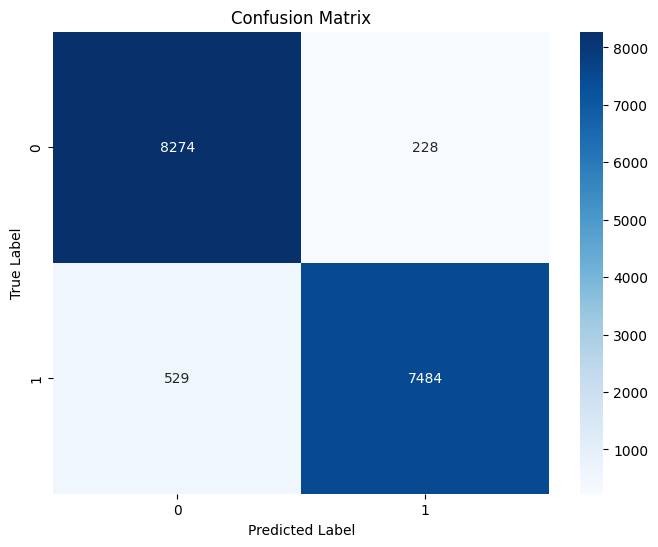

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

history = model.fit(
    train_features_padded, train_labels,
    validation_data=(val_features_padded, val_labels),
    epochs=10,
    batch_size=64
)
test_loss, test_accuracy = model.evaluate(test_features_padded, test_labels)
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities
test_probabilities = model.predict(test_features_padded)
# Convert probabilities to binary predictions (0 or 1)
test_predictions = (test_probabilities > 0.5).astype(int)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# Fit the encoder with the original test labels to get the class names
encoder.fit(test_labels)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [14]:
model.save('/kaggle/working//model.h5')

# video dlib with BERT


In [1]:
pip install dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.4-cp310-cp310-linux_x86_64.whl size=3327201 sha256=82840eede72cf0958c4021ea1c841fbe22d421ee9f132de93d5f8320ca060861
  Stored in directory: /root/.cache/pip/wheels/08/5e/55/a7db8d57920eb2c2aa41c36dc4c6d3cd12323865de191a7211
Successfully built dlib
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import cv2
import dlib
import os
import numpy as np
from transformers import BertTokenizer, BertModel

# Initialize dlib's face detector and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/kaggle/working/shape_predictor_68_face_landmarks.dat')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to process text using BERT and get embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    landmarks = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        
        for face in faces:
            shape = predictor(gray, face)
            landmark = np.array([(part.x, part.y) for part in shape.parts()]).flatten()
            landmarks.append(landmark)
    
    cap.release()
    return landmarks

def process_directory(directory):
    video_landmarks = {}
    
    for label in ['Deceptive', 'Truthful']:
        videos_path = os.path.join(directory, label)
        for video_name in os.listdir(videos_path):
            video_path = os.path.join(videos_path, video_name)
            video_landmarks[video_name[:-4]] = process_video(video_path)
    
    return video_landmarks

# Function to read data from files and combine features
def read_data_from_files(main_directory_text, main_directory_video):
    data = []
    video_landmarks = process_directory(main_directory_video)
    
    for class_folder in os.listdir(main_directory_text):
        class_folder_path_text = os.path.join(main_directory_text, class_folder)
        
        if os.path.isdir(class_folder_path_text):
            text_files = {f[:-4]: f for f in os.listdir(class_folder_path_text) if f.endswith('.txt')}
            
            for base_name, text_file in text_files.items():
                filepath_text = os.path.join(class_folder_path_text, text_file)
                with open(filepath_text, 'r', encoding='utf-8') as file:
                    text = file.read()
                    label = class_folder
                    text_embedding = get_bert_embeddings(text)
                    video_landmark = np.mean(video_landmarks.get(base_name, []), axis=0)
                    print(filepath_text, "Done..!")
                    
                    print("Text Embedding Shape:", text_embedding.shape)
                    print("Text Embedding:", text_embedding)
                    print("Video Landmark Shape:", video_landmark.shape)
                    print("Video Landmark:", video_landmark)
                    
                    if video_landmark.size > 0:  # Check if video_landmark is not empty
                        combined_features = np.concatenate([text_embedding, video_landmark])
                        data.append((combined_features, label))
                    else:
                        print(f"No landmarks found for video {base_name}, skipping.")
    return data

# Example usage
data_directory_text = '/kaggle/input/audio-and-text/Transcription'
data_directory_video = '/kaggle/input/real-life-deception-detection/Real-life_Deception_Detection_2016/Clips'
data = read_data_from_files(data_directory_text, data_directory_video)

# Separate features and labels
features = np.array([d[0] for d in data])
labels = np.array([d[1] for d in data])

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


In [ ]:
df = pd.DataFrame({'landmarks': features, 'label': labels})

In [ ]:
# Split into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# 0.25 x 0.8 = 0.2
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

In [ ]:
# Optionally, save to CSV or another format
train_df.to_csv('train_visual_WithBert_data.csv', index=False)
val_df.to_csv('val_visual_WithBert_data.csv', index=False)
test_df.to_csv('test_visual_WithBert_data.csv', index=False)

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)